# I) ***Importation des modules et de la base brute***

In [ ]:
# Load libraries
import os
import pandas as pd
import numpy as np 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import  DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


os.chdir('D:\\SORBONNE\\M1\\S2\\ProjetPy\\AirbnbPropre')

df = pd.read_csv('VilleFinale1.csv', sep=';')#

# II) ***Traitement des données***

In [21]:
# Création de la varible villes codé
for i in range(len(df["ville"])):
    if df["ville"][i]=="Paris":
        df.at[i,"villes"]=4
    if df["ville"][i]=="Lyon":
        df.at[i,"villes"]=3
    if df["ville"][i]=="Nice":
        df.at[i,"villes"]=2
    if df["ville"][i]=="Toulouse":
        df.at[i,"villes"]=1  

In [22]:
#Création de la variable score
base = df.iloc[:,3:]
base["confort"] = base["wifi"]+base["tv"]+base["clim"] 
base["secu"] = base["detect_fumee"]+base["detect_mono"]+base["kit_secours"]+base["exctincteur"]
base["secondaire"] = base["sèche_cheveux"]+base["cintres"]+base["shampooing"] 
vardel =["wifi","tv","clim","detect_fumee","detect_mono","kit_secours","exctincteur","sèche_cheveux","cintres","shampooing"]
for i in vardel:
    del base[i]
base.shape

(1843, 17)

In [23]:
base.isna().sum()

prix                           0
note                         306
Frais de service            1063
Frais de ménage             1488
Taxes de séjour et frais    1098
nbvoyageur                    57
nbchambre                    413
nblit                         20
nbsalb                        52
log_chpv                       0
log_hotel                      0
log_ent                        0
log_partagé                    0
villes                         0
confort                        0
secu                           0
secondaire                     0
dtype: int64

In [24]:
#Création de la variable totale frais
fraisbase = base[["Frais de service","Frais de ménage","Taxes de séjour et frais"]]


fraisbase.fillna(0, inplace=True)
base["Frais de service"]=fraisbase["Frais de service"]
base["Frais de ménage"]=fraisbase["Frais de ménage"]
base["Taxes de séjour et frais"]=fraisbase["Taxes de séjour et frais"]


base["Total frais"]= base["Frais de ménage"]+base["Frais de service"]+base["Taxes de séjour et frais"]
base.isna().sum()

prix                          0
note                        306
Frais de service              0
Frais de ménage               0
Taxes de séjour et frais      0
nbvoyageur                   57
nbchambre                   413
nblit                        20
nbsalb                       52
log_chpv                      0
log_hotel                     0
log_ent                       0
log_partagé                   0
villes                        0
confort                       0
secu                          0
secondaire                    0
Total frais                   0
dtype: int64

In [25]:
#Imputations des NA de nblit, nbvoyageur et nbchambre
base["nblit"] = base.groupby(['log_hotel', 'log_chpv','log_partagé'])['nblit'].apply(lambda x : x.fillna(round(x.mean())))
base["nbvoyageur"] = base.groupby(['log_hotel', 'log_chpv','log_partagé'])['nbvoyageur'].apply(lambda x : x.fillna(round(x.mean())))
base["nbchambre"] = base.groupby(['log_hotel', 'log_chpv','log_partagé'])['nbchambre'].apply(lambda x : x.fillna(round(x.mean())))
base.isna().sum()

prix                          0
note                        306
Frais de service              0
Frais de ménage               0
Taxes de séjour et frais      0
nbvoyageur                    0
nbchambre                     0
nblit                         0
nbsalb                       52
log_chpv                      0
log_hotel                     0
log_ent                       0
log_partagé                   0
villes                        0
confort                       0
secu                          0
secondaire                    0
Total frais                   0
dtype: int64

In [26]:
#Imputer les NA de nbsalb
base["nbsalb"] = base.groupby(['nbchambre','log_hotel','log_partagé',"log_chpv"])['nbsalb'].apply(lambda x : x.fillna(round(x.mean())))
base.isna().sum()

prix                          0
note                        306
Frais de service              0
Frais de ménage               0
Taxes de séjour et frais      0
nbvoyageur                    0
nbchambre                     0
nblit                         0
nbsalb                        0
log_chpv                      0
log_hotel                     0
log_ent                       0
log_partagé                   0
villes                        0
confort                       0
secu                          0
secondaire                    0
Total frais                   0
dtype: int64

In [27]:
#Imputation NA de note
base["note"] = base.groupby(['confort','secu','log_partagé',"secondaire"])['note'].apply(lambda x : x.fillna(round(x.mean())))
base.isna().sum()

prix                        0
note                        0
Frais de service            0
Frais de ménage             0
Taxes de séjour et frais    0
nbvoyageur                  0
nbchambre                   0
nblit                       0
nbsalb                      0
log_chpv                    0
log_hotel                   0
log_ent                     0
log_partagé                 0
villes                      0
confort                     0
secu                        0
secondaire                  0
Total frais                 0
dtype: int64

# III) ***Selection des variables***

## 1) **Methode de filtrage**

### Corrélation entre la variable cible et les variables explicatives

### Détermination de nos variables X et Y . Y étant la variable sécu. 

In [28]:
Y=base.iloc[:,17]
Y=pd.DataFrame(Y)

In [30]:
Xbrute=base.drop(columns=['secu'])

In [31]:
#Matrice de correction 

corr_matrix = base.corr()
corr_matrix

,prix,note,Frais de service,Frais de ménage,Taxes de séjour et frais,nbvoyageur,nbchambre,nblit,nbsalb,log_chpv,log_hotel,log_ent,log_partagé,villes,confort,secu,secondaire,Total frais
prix,1.000000,0.061303,0.289422,0.150789,0.134394,0.452759,0.104700,0.144839,0.007155,-0.184921,0.062605,0.348694,-0.114850,0.161674,0.031391,0.106217,0.102148,0.217144
note,0.061303,1.000000,0.071236,-0.020673,0.047607,-0.038634,-0.010465,-0.042808,-0.025329,0.030663,-0.022287,-0.106645,-0.140824,-0.032090,0.013547,-0.005632,0.044881,0.015624
Frais de service,0.289422,0.071236,1.000000,0.667151,0.787441,0.117932,-0.011277,0.033078,-0.024157,-0.225528,-0.114990,0.208384,-0.072064,0.034962,-0.000773,-0.042953,0.048713,0.867975
Frais de ménage,0.150789,-0.020673,0.667151,1.000000,0.478585,0.186341,0.006942,0.064806,-0.012334,-0.128759,-0.065650,0.212970,-0.041143,0.003938,0.010466,-0.034280,0.063442,0.947944
Taxes de séjour et frais,0.134394,0.047607,0.787441,0.478585,1.000000,0.031678,-0.031730,-0.006955,-0.035779,-0.249102,-0.127010,0.144912,-0.079597,0.040790,0.004443,-0.040059,0.022483,0.675439
nbvoyageur,0.452759,-0.038634,0.117932,0.186341,0.031678,1.000000,0.446807,0.629166,0.394062,-0.149851,0.022028,0.248978,-0.046516,-0.022107,0.048939,0.104155,0.107868,0.170736
nbchambre,0.104700,-0.010465,-0.011277,0.006942,-0.031730,0.446807,1.000000,0.742283,0.917423,-0.036864,0.208945,-0.014947,-0.012301,0.039677,0.020573,0.104602,0.029052,-0.001498
nblit,0.144839,-0.042808,0.033078,0.064806,-0.006955,0.629166,0.742283,1.000000,0.767601,-0.064762,0.134795,0.015179,0.062562,0.003510,0.037420,0.105107,0.052953,0.055319
nbsalb,0.007155,-0.025329,-0.024157,-0.012334,-0.035779,0.394062,0.917423,0.767601,1.000000,-0.014078,0.233121,-0.043415,-0.005096,0.049514,0.012060,0.089264,0.023335,-0.019461
log_chpv,-0.184921,0.030663,-0.225528,-0.128759,-0.249102,-0.149851,-0.036864,-0.064762,-0.014078,1.000000,-0.060330,-0.327043,-0.037809,0.005258,0.011181,-0.044390,-0.062787,-0.185596


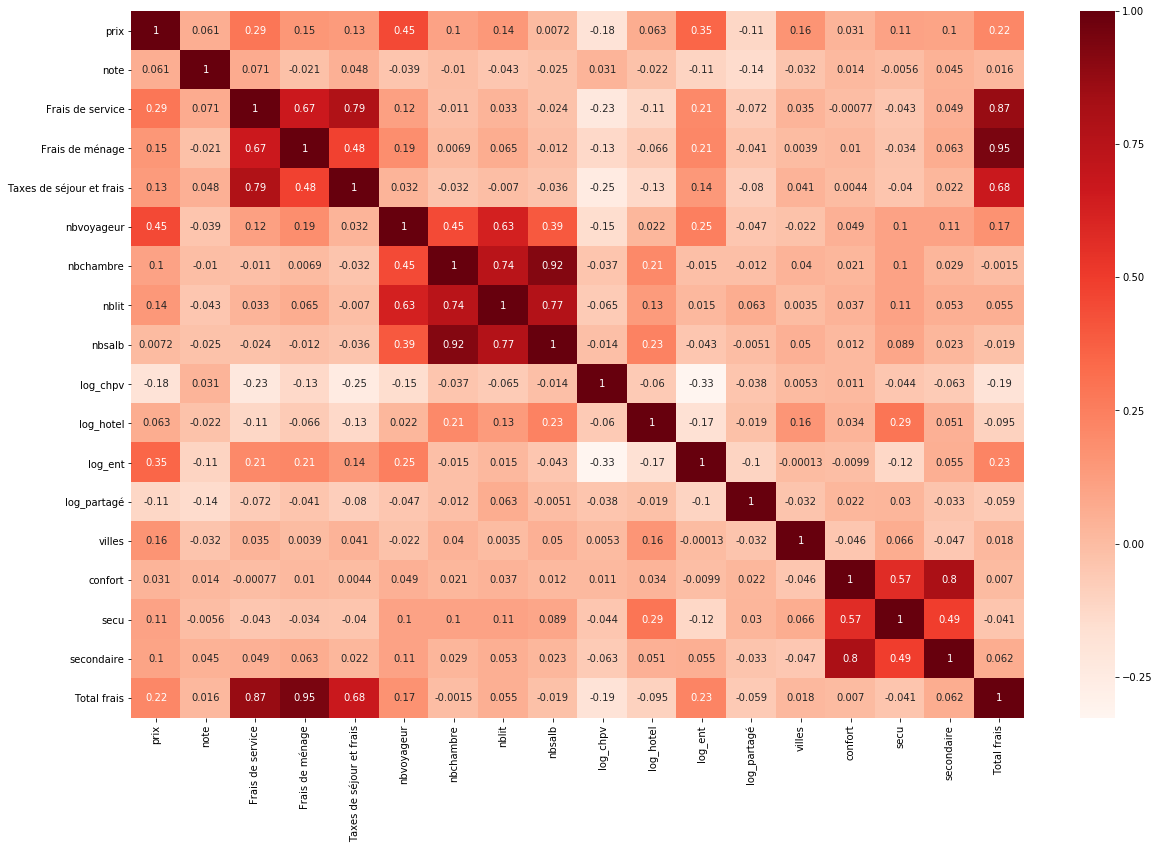

In [32]:
#Using Pearson Correlation 
plt.figure (figsize = (20,13)) 
cor = base.corr () 
sns.heatmap (cor, annot = True, cmap = plt.cm.Reds) 
plt.show ()

In [33]:
#Sélection de caractéristiques hautement corrélées 
cor_target = abs (cor ["secu"])
relevant_features = cor_target [cor_target> 0.1] 
relevant_features

prix          0.106217
nbvoyageur    0.104155
nbchambre     0.104602
nblit         0.105107
log_hotel     0.292172
log_ent       0.123135
confort       0.570456
secu          1.000000
secondaire    0.492149
Name: secu, dtype: float64

In [34]:
#Les variable linéairements pertinantes linéairemetn corrélés au prix de façon pertinente
LesCorrLin = relevant_features.index.tolist()
basecol = base.columns.tolist()
for x in LesCorrLin :
    basecol.remove(x)
CorrNonLin = basecol
CorrNonLin

['note',
 'Frais de service',
 'Frais de ménage',
 'Taxes de séjour et frais',
 'nbsalb',
 'log_chpv',
 'log_partagé',
 'villes',
 'Total frais']

### Corrélation non linéaire 

In [35]:
#Test de la corrélation des variables non linéaire par rapport à 'sécu' test de corrélation p/r à 'secu'
ListNonLin=[]
for i in CorrNonLin:
    ListNonLin.append(scipy.stats.kendalltau(base["secu"],base[i]) )
ListNonLin

[KendalltauResult(correlation=-0.01368481746983933, pvalue=0.47888035775213234),
 KendalltauResult(correlation=-0.05941851692838754, pvalue=0.003335571104856223),
 KendalltauResult(correlation=-0.03437169576258274, pvalue=0.10625556891858647),
 KendalltauResult(correlation=-0.04400997979502992, pvalue=0.0353086341929705),
 KendalltauResult(correlation=0.042757090374703044, pvalue=0.05315022032719971),
 KendalltauResult(correlation=-0.04588997628427779, pvalue=0.03913565673282391),
 KendalltauResult(correlation=0.04272146747247321, pvalue=0.05481585254963398),
 KendalltauResult(correlation=0.06340879031103473, pvalue=0.0018251508899232178),
 KendalltauResult(correlation=-0.055229511337435346, pvalue=0.0059217922645062775)]

In [36]:
#On fait une Somme entre variables linéairement pertinentes et non linéairement pertinentes et on a mis ça dans la variable FilterCorr
#Les variables ajoutées sont celles où l'hypothèse nulle n'est pas rejetée.Rejetter l'hypothèse que les corrélations ne sont pas linéaires suppose donc que les variables sont linéaires 
FilterCorr = LesCorrLin + ['Frais de service' , 'Taxes de séjour et frais','log_chpv','villes','Total frais']
FilterCorr

['prix',
 'nbvoyageur',
 'nbchambre',
 'nblit',
 'log_hotel',
 'log_ent',
 'confort',
 'secu',
 'secondaire',
 'Frais de service',
 'Taxes de séjour et frais',
 'log_chpv',
 'villes',
 'Total frais']

### Corrélation entre les variables explicatives

In [37]:
#Suppression de la variable 'secu' dans FilterCorr
FilterCorr.remove('secu')

In [38]:
FilterCorr

['prix',
 'nbvoyageur',
 'nbchambre',
 'nblit',
 'log_hotel',
 'log_ent',
 'confort',
 'secondaire',
 'Frais de service',
 'Taxes de séjour et frais',
 'log_chpv',
 'villes',
 'Total frais']

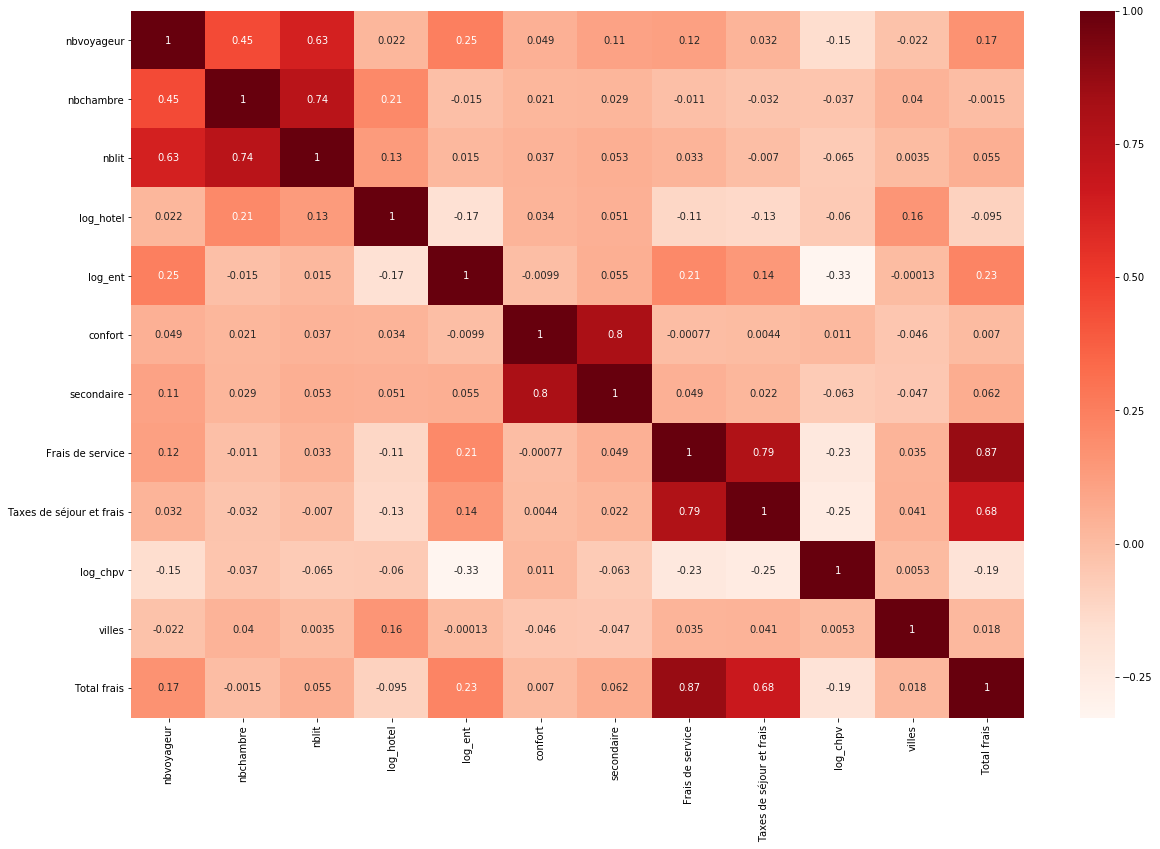

In [39]:
#Etude des corrélations entre variables explicatives 
InterCorr =  FilterCorr[1:]
baseSec = base[InterCorr]
plt.figure (figsize = (20,13)) 
cor = baseSec.corr () 
sns.heatmap (cor, annot = True, cmap = plt.cm.Reds) 
plt.show ()

In [40]:
#On prend celles qui sont > 0.6 
corr_features = cor[abs (cor)> 0.6] 
corr_features = corr_features.where(~(corr_features==1))
corr_features

,nbvoyageur,nbchambre,nblit,log_hotel,log_ent,confort,secondaire,Frais de service,Taxes de séjour et frais,log_chpv,villes,Total frais
nbvoyageur,NaN,NaN,0.629166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nbchambre,NaN,NaN,0.742283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nblit,0.629166,0.742283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_hotel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_ent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
confort,NaN,NaN,NaN,NaN,NaN,NaN,0.804218,NaN,NaN,NaN,NaN,NaN
secondaire,NaN,NaN,NaN,NaN,NaN,0.804218,NaN,NaN,NaN,NaN,NaN,NaN
Frais de service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.787441,NaN,NaN,0.867975
Taxes de séjour et frais,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.787441,NaN,NaN,NaN,0.675439
log_chpv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#Obtention de la Base de données totales au niveau de la méthode de sélection des variables basée sur les corrélations
AutoCorr = ["nblit","secondaire","Frais de service", "Taxes de séjour et frais"]
for x in AutoCorr:
    FilterCorr.remove(x)
FilterCorr
Xcorr = base[FilterCorr]

In [42]:
FilterCorr

['prix',
 'nbvoyageur',
 'nbchambre',
 'log_hotel',
 'log_ent',
 'confort',
 'log_chpv',
 'villes',
 'Total frais']

# **Cross validation Classification**

# **Méthode Lasso** 

### On fait une régression et on obtient un plot qui nous donne le poids de chaque variable dans ta variable cible . A partir de là on obtient une base de données construite  à partir de la méthode de sélection appelée Lasso

In [85]:
X=Xbrute
²
clf = LassoCV()
clf.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % clf.alpha_)
print("Best score using built-in LassoCV: %f" %clf.score(X,Y))
X=pd.DataFrame(X)
coef = pd.Series(clf.coef_,index=X.columns)

Best alpha using built-in LassoCV: 0.037832
Best score using built-in LassoCV: 0.814523


C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, "Importance des fonctionnalités à l'aide du modèle Lasso")

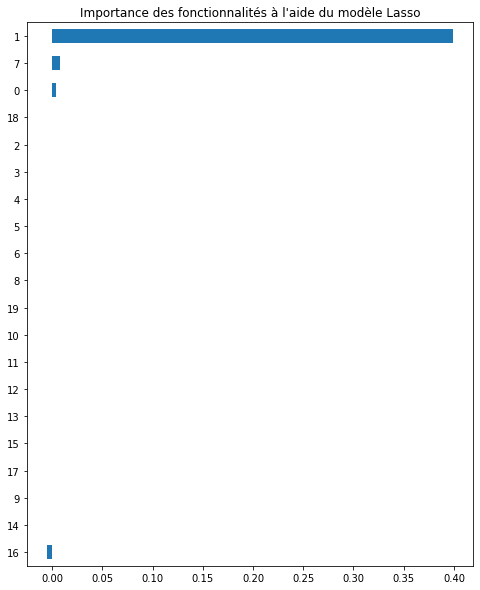

In [86]:
imp_coef = coef.sort_values() 
matplotlib.rcParams ['figure.figsize'] = (8.0, 10.0) 
imp_coef.plot (kind = "barh") 
plt.title ("Importance des fonctionnalités à l'aide du modèle Lasso")

In [91]:
LossVar = imp_coef.index.where(imp_coef!=0)
LossVar = pd.DataFrame(LossVar)
LossVar = LossVar[~(LossVar==np.nan)].iloc[:,0].unique().tolist()
del LossVar[2]
LossVar
for i in range(len(LossVar)):
    LossVar[i]=int(LossVar[i])
VarLoss=Xbrute.columns
VarLoss=VarLoss[LossVar]
VarLoss=VarLoss.tolist()
Xloss = base[VarLoss]
Xloss.head()

,Total frais,confort,prix,nblit,note
0,0.0,3.0,20.0,1.0,4.5
1,0.0,3.0,14.0,1.0,4.6
2,21.0,3.0,42.0,2.0,4.6
3,0.0,3.0,14.0,3.0,4.6
4,0.0,3.0,28.0,0.0,5.0


## 4) **Détermination des meilleures variables**
### selon l'intersection des bases

In [93]:
# Les meilleures variables: obtenu à partir des 3 méthodes 

BestVar = set(VarLoss)&set(FilterCorr)
BestVar = list(BestVar)
Xbest=base[BestVar]
BestVar

['prix', 'Total frais', 'confort']

# IV) ***Lancement des modèles***

In [95]:
#Lance les 3 algorithmes sur la base de données obtenu et on obtient moyenne écart type etc et il nous dit que le meilleur aloorithme est le gradient boostique et la meilleur modélaisation est la est la brute qui donne le meilleur score par la Gradient Boosting. 
#Meilleure modélisation = prix = prise en compte de toutes les variables
Xtot= [("Brute",Xbrute),("VarCorr",Xcorr),("VarLoss",Xloss),("VarBest",Xbest)]
index=[]
colonne=[]
for j,i in models:
    index.append(j) 
    
    
for col,i in Xtot:
    colonne.append(col)
    
results = []
noms = []
TabSorti = pd.DataFrame(index = index, columns = colonne)
ScoreBest =0
for nomdata, X in Xtot:
    #Mettre à l'echelle les donnéesµ
    X_train, X_test, Y_train, Y_test = train_test_split(X , Y, test_size=0.20, random_state=1)
    scaler = StandardScaler()
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    for nomodel, modele in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(modele, X_train, Y_train, cv=10)
        scor = cv_results.mean()
        TabSorti.at[nomodel, nomdata]= scor
        if scor>  ScoreBest :
            BestModel = nomodel
            mod = modele
            BestData = nomdata
            ScoreBest = scor
            Sqrt =cv_results.std()
            bX_train, bX_test, bY_train, bY_test = X_train, X_test, Y_train, Y_test

            

print("Meilleur model : ",BestModel,"\n","Meilleure modelisation :",BestData)
print("Sa moyenne : ", ScoreBest, "\n","Son Ecart-type",Sqrt)
print("Table de sortie")
TabSorti

C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

Meilleur model :  GNB 
 Meilleure modelisation : Brute
Sa moyenne :  0.975 
 Son Ecart-type 0.049999999999999996
Table de sortie


C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gasto\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

,Brute,VarCorr,VarLoss,VarBest
GNB,0.975,0.975,0.975,0.975
GBC,0.901389,0.901389,0.901389,0.901389
RFC,0.926389,0.9375,0.925,0.95
DTC,0.9375,0.95,0.95,0.95


In [99]:
# Evaluation du selectionné
mod.fit(bX_train, bY_train)
y_pred=mod.predict(bX_test) 
print("\n","R2 lors de l'entrainement")
print(mod.score(bX_train, bY_train))
print("\n","R2 lors du test")
print(mod.score(bX_test, bY_test))


 R2 lors de l'entrainement
0.975

 R2 lors du test
0.9
